This notebook loads data stored in text files, formats and stored into pandas dataframes. Some additional producs are computed and stored in dataframes, including uncertainty band and chl anomaly. The dataframes are then pickled for plotting in a later notebook.

In [60]:
import pandas as pd
import pathlib
from datetime import datetime
import pickle
from scipy.stats import mode
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.pyplot as pl
from matplotlib import rcParams
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import pymc3 as pm

In [2]:
%matplotlib inline

In [102]:
def convert_secs2dt(sec):
    """
    Converts seconds to python datetime object.
    :param sec 
    :return: datetime object
    """
    zd00 = datetime(2000, 1, 1)
    zd70 = datetime(1970, 1, 1)
    offset = (zd00 - zd70).total_seconds()
    z = datetime.utcfromtimestamp(sec + offset)
    return z


def get_doy(secs):
    """
    Converts seconds to fractional day of year.
    :param secs
    :return: fractional day of year 
    """
    z = convert_secs2dt(secs)
    y = z.year
    return (secs + (datetime(2000, 1, 1) - datetime(y, 1, 1)).total_seconds()) / 86400


def load_format_data(filepath, minimal=True, columns=None, quantity='chl_a'):
    """
    Loads chlorophyll data into a pandas dataframe,
    formats time entries, and creates a datetime index.
    :param filepath: string or pathlib object  
    :param minimal: if True returns only chl_a_mean; drops the rest.
    :return: pandas datetime indexed dataframe
    """
    if columns is None:
        columns = ['time', 'nbins', 'mean', 'median', 'stdv']
    
    df = pd.read_csv(filepath, delim_whitespace=True, names=columns)
    df['datetime'] = df.time.apply(convert_secs2dt)
    df.set_index('datetime', inplace=True)
    if minimal:
        df = df[['mean']]
    df.rename(columns={'mean': '%s_mean' % quantity}, inplace=True)
    return df


def regress_phyto_c(df, mean_col_label='bbp_443_giop_mean',
                   reg_slope=12128, reg_bias=0.59):
    df['phyto_c'] = df[mean_col_label] * reg_slope + reg_bias
    return df


def get_monthly_means(df, **kwargs):
    """
    Groups data by month and compute annual cycle based on monthly means.
    :param df: 
        datetime indexed pandas dataframe
    :param kwargs:
        year_start (optional): string, slice start
        year_end (optional): string, slice end
    :return: 
        month-indexed pandas dataframe with monthly means
    """
    year_start = kwargs.pop('year_start', df.index.year[0])
    year_end = kwargs.pop('year_end', df.index.year[-1])
    return df.loc[str(year_start): str(year_end)].groupby(lambda x: x.month).aggregate('mean')


def get_anomaly(df, df_ann_cycle, name='chl_a_mean', anomaly_name='anomaly'):
    """
    Computes annomaly by removing monthly mean for a given month
    :param df:
        pandas dataframe with [name] parameter column
    :param df_ann_cycle:
        pandas dataframe of length 12 containing monthly means
    :param name:
        str, label of quantity to get anomaly from
    :return:
        None
    """

    for month in df_ann_cycle.index:
        idx = df.index.month == month
        df.loc[idx, anomaly_name] = df.loc[idx, name] - df_ann_cycle.loc[month, name]


def test(datadir):
    testfile = datadir / 'ar2018.0m_AtlN55_chlor_a.txt'
    df_test = load_format_data(testfile, minimal=False)
    t0 = df_test.time[0]    
    z0 = convert_secs2dt(t0)
    zstr0 = z0.strftime('%Y%j%H%M%S')
    try:
        assert zstr0 + '000' == str(2002197194740000)
    except AssertionError as e:
        print(e)
        print(zstr0)
    assert z0.year == 2002
    doy0 = get_doy(t0)
    assert doy0 == 196.82476851851851
    tl = df_test.tail(1).time.values
    zl = convert_secs2dt(tl)
    zstrl = zl.strftime('%Y%j%H%M%S')
    assert zstrl + '000' == str(2016321013320000)
    assert zl.year == 2016
    doyl = get_doy(tl)
    assert doyl == 320.06481481481484
    print("all tests passed")

In [64]:
# Global graphics setup
display(HTML("<style>.container {width: 90%}</style>"))
plot_colors = {'consolidated': '#000000',
               'aqua': '#348ABD',
               'swf': '#A60628',
               'mei': '#467821',
               }
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['font.size'] = 15
rcParams['ytick.major.size'] = 8
rcParams['ytick.minor.size'] = 3
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 3
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'
rcParams['axes.formatter.limits'] = (-2, 3)

In [5]:
# Paths
home = pathlib.Path.home()
dataMain = home / 'DEV-ALL/State_of_the_Climate/soc2018/TIMESERIES/'
test_aquadir = dataMain / 'ar2018.0m_ar2018.0m/stats'

aquadir = dataMain / 'ar2018.0m_ar2018.0m/stats'
aquaIOPdir = dataMain / 'ar2018.0IOPm_ar2018.0IOPm/stats'

swfdir = dataMain / 'sr2018.0m_sr2018.0m/stats'
swfIOPdir = dataMain / 'sr2018.0IOPm_sr2018.0IOPm/stats'

fp_chlor_a_aqua = aquadir / 'ar2018.0m_eqsst_chlor_a.txt'
fp_chlor_a_swf = swfdir / 'sr2018.0m_eqsst_chlor_a.txt'

fp_bbp_443_giop_aqua = aquaIOPdir / 'ar2018.0IOPm_eqsst_bbp_443_giop.txt'
fp_bbp_443_giop_swf = swfIOPdir / 'sr2018.0IOPm_eqsst_bbp_443_giop.txt'
#test(test_aquadir)

In [103]:
# Load the data into pandas dataframes, with some datetime formatting
df_swf = load_format_data(fp_chlor_a_swf,)
df_aqua = load_format_data(fp_chlor_a_aqua)

df_swf_bbp = load_format_data(fp_bbp_443_giop_swf, quantity='bbp_443_giop')
df_aqua_bbp = load_format_data(fp_bbp_443_giop_aqua, quantity='bbp_443_giop')

In [110]:
df_aqua_bbp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194 entries, 2002-07-15 to 2018-08-15
Data columns (total 1 columns):
bbp_443_giop_mean    194 non-null float64
dtypes: float64(1)
memory usage: 3.0 KB


In [111]:
df_aqua.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191 entries, 2002-07-15 to 2018-05-15
Data columns (total 1 columns):
chl_a_mean    191 non-null float64
dtypes: float64(1)
memory usage: 8.0 KB


In [7]:
with open('./pklJar/pooled_params.pkl', 'rb') as fb:
    pooled_params_dict = pickle.load(fb)

In [8]:
slope = pooled_params_dict['slope']

In [9]:
slope = slope.reshape(-1, 1)

In [10]:
intercept = pooled_params_dict['intercept']

In [11]:
intercept = intercept.reshape(-1, 1)

In [61]:
def set_time_axis(ax):
    x_minorlocator = mdates.YearLocator()
    x_majorformatter = mdates.DateFormatter('%b\n%Y')
    ax.xaxis.set_minor_locator(x_minorlocator)
    ax.xaxis.set_tick_params(rotation=0)
    ax.xaxis.set_major_formatter(x_majorformatter)
    ax.set_xlabel('')
    
def compute_phyto_C_stats(df_):
    bbp_443_ = df_.bbp_443_giop_mean.values.reshape(1,-1)
    phyto_c_trace_ = intercept + bbp_443_ * slope
    phyto_c_mean = phyto_c_trace_.mean(axis=0)
    phyto_c_hpd = pm.hpd(phyto_c_trace_)
    df_.insert(loc=1, column='phyto_C_2.5%', value=phyto_c_hpd[:, 0])
    df_.insert(loc=2, column='phyto_C_97.5%', value=phyto_c_hpd[:, 1])
    df_.insert(loc=2, column='phyto_C_mean', value=phyto_c_mean)

In [101]:
df_aqua.tail()

,chl_a_mean
datetime,
2018-01-16 13:13:20,0.144528
2018-02-15 01:31:40,0.144109
2018-03-16 13:40:00,0.142470
2018-04-16 01:21:40,0.139971
2018-05-16 13:50:00,0.144199


In [105]:
df_a = pd.concat((df_aqua, df_aqua_bbp), axis=1)

In [106]:
df_a.tail()

,chl_a_mean,bbp_443_giop_mean
datetime,,
2018-04-15,0.139971,0.001800
2018-05-15,0.144199,0.001813
2018-06-15,NaN,0.001798
2018-07-15,NaN,0.001767
2018-08-15,NaN,0.001792


In [14]:
df_s = pd.concat((df_swf, df_swf_bbp), axis=1)

In [15]:
df_s.columns = ['s_%s' % col for col in df_s.columns]

In [16]:
swf_good_per_ends = '2007-12-31'

In [17]:
df_s = df_s.loc[:swf_good_per_ends]

In [18]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 1997-11-15 22:47:10 to 2007-12-16 10:50:00
Data columns (total 2 columns):
s_chl_a_mean           122 non-null float64
s_bbp_443_giop_mean    122 non-null float64
dtypes: float64(2)
memory usage: 2.9 KB


In [19]:
df_a.columns = ['a_%s' % col for col in df_a.columns]

In [20]:
df_all = pd.concat(
                    (df_s.resample('MS', loffset=pd.Timedelta(14, 'd')).first(),
                    df_a.resample('MS', loffset=pd.Timedelta(14, 'd')).first()),
    axis=1)

In [21]:
df_all.head()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean
datetime,,,,
1997-11-15,0.128396,0.001788,NaN,NaN
1997-12-15,0.128360,0.001712,NaN,NaN
1998-01-15,0.128007,0.001673,NaN,NaN
1998-02-15,0.126971,0.001660,NaN,NaN
1998-03-15,0.128490,0.001686,NaN,NaN


In [95]:
df_all.tail()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean,adj_chl_s,adj_chl_a,adj_bbp_s,adj_bbp_a,chl_adj_mean,bbp_adj_mean
datetime,,,,,,,,,,
2018-04-15,NaN,NaN,0.139971,0.001800,NaN,0.141815,NaN,0.001746,0.141815,0.001746
2018-05-15,NaN,NaN,0.144199,0.001813,NaN,0.146043,NaN,0.001760,0.146043,0.001760
2018-06-15,NaN,NaN,NaN,0.001798,NaN,NaN,NaN,0.001744,NaN,0.001744
2018-07-15,NaN,NaN,NaN,0.001767,NaN,NaN,NaN,0.001714,NaN,0.001714
2018-08-15,NaN,NaN,NaN,0.001792,NaN,NaN,NaN,0.001739,NaN,0.001739


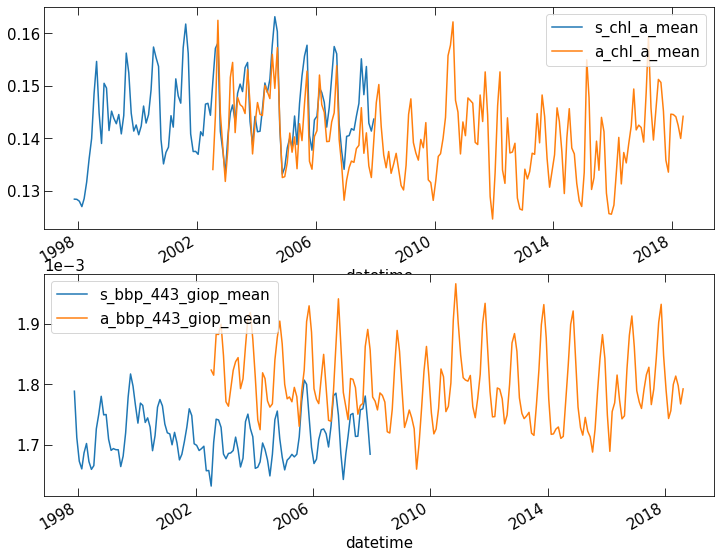

In [65]:
_, ax = pl.subplots(nrows=2, figsize=(12, 10))
df_all.plot(y=['s_chl_a_mean', 'a_chl_a_mean'], ax=ax[0])
df_all.plot(y=['s_bbp_443_giop_mean', 'a_bbp_443_giop_mean'], ax=ax[1])

In [46]:
df_both=df_all.dropna().copy()

In [47]:
df_both.insert(0, 'chl_mean',
               df_both[['s_chl_a_mean',
                        'a_chl_a_mean']].mean(axis=1))
df_both.insert(1, 'bbp443_mean',
               df_both[['s_bbp_443_giop_mean',
                        'a_bbp_443_giop_mean']].mean(axis=1))

In [48]:
df_both.insert(1, 'aqua-chl_mean', df_both.a_chl_a_mean - df_both.chl_mean)
df_both.insert(1, 'chl_mean-swf', df_both.chl_mean - df_both.s_chl_a_mean)

In [49]:
df_both.insert(4, 'aqua-bbp443_mean', df_both.a_bbp_443_giop_mean - df_both.bbp443_mean)
df_both.insert(4, 'bbp443_mean-swf', df_both.bbp443_mean - df_both.s_bbp_443_giop_mean)

In [50]:
df_both.head().T

datetime,2002-07-15 00:00:00,2002-08-15 00:00:00,2002-09-15 00:00:00,2002-10-15 00:00:00,2002-11-15 00:00:00
chl_mean,0.142464,0.150699,0.160347,0.143069,0.137818
chl_mean-swf,-0.008418,-0.006461,0.002158,0.001746,0.000251
aqua-chl_mean,-0.008418,-0.006460,0.002159,0.001746,0.000251
bbp443_mean,0.001727,0.001759,0.001812,0.001811,0.001814
bbp443_mean-swf,0.000096,0.000056,0.000070,0.000071,0.000085
aqua-bbp443_mean,0.000096,0.000056,0.000070,0.000071,0.000085
s_chl_a_mean,0.150883,0.157160,0.158189,0.141323,0.137566
s_bbp_443_giop_mean,0.001632,0.001704,0.001742,0.001741,0.001729
a_chl_a_mean,0.134046,0.144239,0.162506,0.144815,0.138069
a_bbp_443_giop_mean,0.001823,0.001815,0.001882,0.001882,0.001899


In [51]:
df_all['adj_chl_s'] = df_all.s_chl_a_mean + df_both['chl_mean-swf'].mean()

In [ ]:
df_all['adj_chl_a'] = df_all.a_chl_a_mean - df_both['aqua-chl_mean'].mean()
df_all['adj_bbp_s'] = df_all.s_bbp_443_giop_mean + df_both['bbp443_mean-swf'].mean()

In [54]:
df_all['adj_bbp_a'] = df_all.a_bbp_443_giop_mean - df_both['aqua-bbp443_mean'].mean()

In [57]:
df_all['chl_adj_mean'] = df_all[['adj_chl_s', 'adj_chl_a']].mean(axis=1)
df_all['bbp_adj_mean'] = df_all[['adj_bbp_s', 'adj_bbp_a']].mean(axis=1)

In [94]:
df_all['adj_chl_a'].tail()

datetime
2018-04-15    0.141815
2018-05-15    0.146043
2018-06-15         NaN
2018-07-15         NaN
2018-08-15         NaN
Name: adj_chl_a, dtype: float64

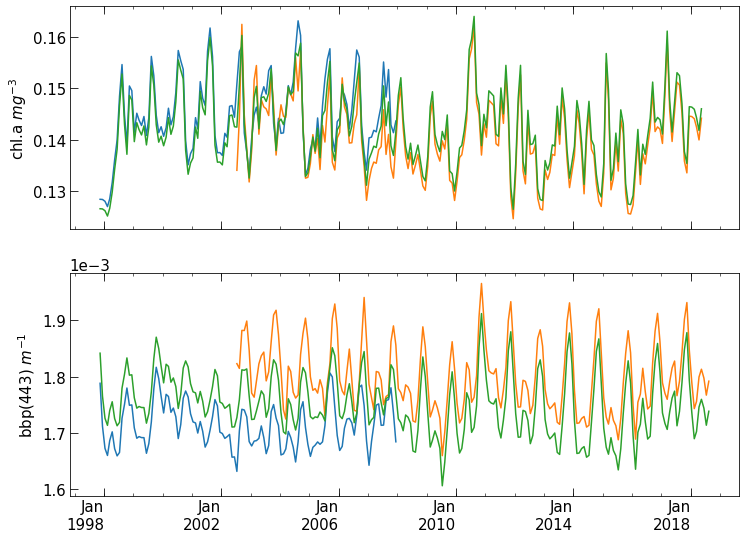

In [70]:
f, ax = pl.subplots(nrows=2, figsize=(12, 10), sharex=True)
df_all.plot(y=['s_chl_a_mean', 'a_chl_a_mean', 'chl_adj_mean'], ax=ax[0], legend=False)
df_all.plot(y=['s_bbp_443_giop_mean', 'a_bbp_443_giop_mean', 'bbp_adj_mean'], ax=ax[1], legend=False)
ax[0].set_ylabel('chl.a $mg^{-3}$')
ax[1].set_ylabel('bbp(443) $m^{-1}$')
set_time_axis(ax[0])
set_time_axis(ax[1])

In [72]:
df_both = df_all[['chl_adj_mean', 'bbp_adj_mean']].copy()

In [76]:
intercept.shape

(8000, 1)

In [77]:
phyto_C_trace = df_both.bbp_adj_mean.values.reshape(1,-1) * slope + intercept

In [79]:
df_both['phyto_C_mean'] = phyto_C_trace.mean(axis=0)

In [81]:
phyto_C_50ci = pm.hpd(phyto_C_trace, alpha=0.5)
phyto_C_95ci = pm.hpd(phyto_C_trace, alpha=0.05)

In [83]:
df_both['phyto_C_50CI_hi'] = phyto_C_50ci[:, 1]
df_both['phyto_C_95CI_hi'] = phyto_C_95ci[:, 1]

In [84]:
df_both.insert(2, 'phyto_C_50CI_lo', phyto_C_50ci[:, 0])
df_both.insert(2, 'phyto_C_95CI_lo', phyto_C_95ci[:, 0])

In [85]:
df_both.head()

,chl_adj_mean,bbp_adj_mean,phyto_C_95CI_lo,phyto_C_50CI_lo,phyto_C_mean,phyto_C_50CI_hi,phyto_C_95CI_hi
datetime,,,,,,,
1997-11-15,0.126552,0.001842,20.385325,21.552935,22.120413,22.762124,24.021646
1997-12-15,0.126516,0.001765,19.559207,20.546520,21.218630,21.699756,23.046890
1998-01-15,0.126163,0.001726,19.085081,20.162330,20.758506,21.287907,22.512791
1998-02-15,0.125127,0.001713,18.944551,20.015984,20.610071,21.132228,22.340050
1998-03-15,0.126646,0.001740,19.345028,20.307371,20.920938,21.442327,22.798734


In [86]:
chl_ann_cycle = get_monthly_means(df_both[['chl_adj_mean']],
                                 year_start=2003, year_end=2011)
carb_ann_cycle = get_monthly_means(df_both[['phyto_C_mean']],
                                  year_start=2003, year_end=2011)

In [87]:
chl_ann_cycle

,chl_adj_mean
1,0.140039
2,0.145164
3,0.144552
4,0.143244
5,0.141956
6,0.144788
7,0.148271
8,0.148510
9,0.150857
10,0.140950


In [88]:
carb_ann_cycle

,phyto_C_mean
1,20.828649
2,20.601835
3,20.644877
4,20.954828
5,21.080523
6,20.830466
7,20.413331
8,20.701994
9,21.205369
10,21.871659


In [89]:
get_anomaly(df_both, chl_ann_cycle, name='chl_adj_mean', anomaly_name='chl_anomaly')
get_anomaly(df_both, carb_ann_cycle, name='phyto_C_mean', anomaly_name='phyto_C_anomaly')

In [90]:
df_both.head().T

datetime,1997-11-15 00:00:00,1997-12-15 00:00:00,1998-01-15 00:00:00,1998-02-15 00:00:00,1998-03-15 00:00:00
chl_adj_mean,0.126552,0.126516,0.126163,0.125127,0.126646
bbp_adj_mean,0.001842,0.001765,0.001726,0.001713,0.001740
phyto_C_95CI_lo,20.385325,19.559207,19.085081,18.944551,19.345028
phyto_C_50CI_lo,21.552935,20.546520,20.162330,20.015984,20.307371
phyto_C_mean,22.120413,21.218630,20.758506,20.610071,20.920938
phyto_C_50CI_hi,22.762124,21.699756,21.287907,21.132228,21.442327
phyto_C_95CI_hi,24.021646,23.046890,22.512791,22.340050,22.798734
chl_anomaly,-0.008520,-0.009597,-0.013876,-0.020037,-0.017906
phyto_C_anomaly,0.021044,-0.304126,-0.070143,0.008237,0.276061


In [92]:
df_both.to_pickle('./pklJar/df_consolidated.pkl')
df_all.to_pickle('./pklJar/df_all.pkl')